<img src="../images/diamond.png" alt="Drawing" style="width: 150px;"/>

# **Diamond Datasheet** 
## **NotebookML 002**

***

## Machine Learning Models

***


In [13]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV , GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', None)

In [3]:
df=pd.read_parquet('../data/processed/df.parquet')
dfd=pd.read_parquet('../data/processed/dfd.parquet')


***

### Test columns

***

Change columns and test which columns fit the most and give a better prediction


In [4]:
dfd.columns

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'df_original', 'id',
       'cut_int', 'color_int', 'clarity_int', 'cut_color_clarity_score',
       'raw_density', 'marketing_carat_int', 'carat_sqr', 'high', 'cut_Fair',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D',
       'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J',
       'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'marketing_carat_bad',
       'marketing_carat_good', 'marketing_carat_regular'],
      dtype='object')

In [5]:
#option 1

# dfd=dfd.drop(columns=['marketing_carat_int','cut_int','color_int', 'clarity_int'])

#option 2
dfd=dfd.drop(columns=['marketing_carat_int', 'cut_int','color_int', 'clarity_int',
                     'marketing_carat_bad',
       'marketing_carat_good', 'marketing_carat_regular','cut_color_clarity_score','high'])

In [6]:

#Option 1

df=df.drop(columns=['cut','color', 'clarity','marketing_carat','cut_color_clarity_score','marketing_carat_int',
                    'raw_density'])

#Option 2

# #df=df.drop(columns=['cut','color', 'clarity','marketing_carat','marketing_carat_int','cut_color_clarity_score','carat_sqr'])



***

### Test Rows

***

Change rows and test which columns fit the most and give a better prediction


In [7]:
df_final=df

data=df_final.loc[df['df_original']==1]
df_predict=df_final.loc[df['df_original']==0]

In [8]:
# def remove_outlier(df, col):
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     iqr = q3-q1 
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_clean = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]
#     return df_clean

data=data.drop_duplicates(subset=data.columns, keep='first')

data['depth_calc'] = data['z'] / ((data['x'] + data['y'])/2)*100
data['rest']=data['depth_calc'] - data['depth'] 
filter_rest=(data['rest']<-1) | (data['rest']>1)
data=data.loc[~filter_rest]
data=data.drop(columns=['depth_calc','rest'],axis=1)

filter_xyz=(data['x']<0.2) | (data['y']<0.2) | (data['z']<0.2)
data=data.loc[~filter_xyz ]


***

### Test Split

***

Split the datasheet to train train diamonds with carat above 1.54 on one side and those with carat below  1.54 on the other.

This made good results in the public score but wrong in the private score.

In [9]:


####################################################################
thres=1.54

df_predict2=df_predict.loc[df_predict['carat']<thres]
data2=data.loc[data['carat']<thres]

X2=data2.drop(columns=['price','df_original','id'])
Y2=data2['price']

X_predict2=df_predict2.drop(columns=['price','df_original','id'])


df_predict3=df_predict.loc[df_predict['carat']>=thres]
data3=data.loc[data['carat']>=thres]

X3=data3.drop(columns=['price','df_original','id'])
Y3=data3['price']

X_predict3=df_predict3.drop(columns=['price','df_original','id'])


#############################################################################33

X=data.drop(columns=['price','df_original','id'])
Y=data['price']

X_predict=df_predict.drop(columns=['price','df_original','id'])


# rs = RobustScaler() 
# X = pd.DataFrame(rs.fit_transform(X), columns= X.columns)
# X_predict = pd.DataFrame(rs.fit_transform(X_predict), columns= X_predict.columns)


df_predict.to_csv('../data/processed/df_predict.csv',index=False)
X.to_csv('../data/processed/X.csv',index=False)
Y.to_csv('../data/processed/Y.csv',index=False)
X_predict.to_csv('../data/processed/X_predict.csv',index=False)





***

### Model Generator

***

Finally I use the Meta model StackingRegressor with the models XGBRegressor, CatBoostRegressor, LGBMRegressor anda the final estimator LinearRegression.

In [16]:

# estimators=[('XGBRegressor' ,  XGBRegressor( base_score=0.6,learning_rate=0.06,max_depth= 6 ,n_estimators=106,booster = 'gbtree' ,n_jobs = -1,gamma=0.0,min_child_weight=3,reg_alpha=0.1,subsample=0.9)),
#            ('ExtraTreesRegressor',ExtraTreesRegressor(max_depth=13, min_samples_split=7,max_features=8, n_estimators=100,n_jobs = -1)),
#            ('GradientBoostingRegressor',GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104, random_state=48)),
#             ('CatBoostRegressor',CatBoostRegressor(silent=True)),
#             ('LGBM' , LGBMRegressor( )),
            
#         ]



estimators=[('XGBRegressor' ,  XGBRegressor( base_score=0.6,learning_rate=0.06,max_depth= 6 ,n_estimators=106,booster = 'gbtree' ,n_jobs = -1,gamma=0.0,min_child_weight=3,reg_alpha=0.1,subsample=0.9)),
            ('CatBoostRegressor',CatBoostRegressor(silent=True)),
            ('LGBM' , LGBMRegressor( n_estimators=65)),
            
        ]

# machine = [ExtraTreesRegressor(max_depth=13, min_samples_split=7,max_features=8, n_estimators=100,n_jobs = -1),
#            GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104, random_state=48),
#            CatBoostRegressor(silent=True),
#            LGBMRegressor( ),
#             XGBRegressor( base_score=0.6,learning_rate=0.06,max_depth= 6 ,n_estimators=106,booster = 'gbtree' ,n_jobs = -1,gamma=0.0,min_child_weight=3,reg_alpha=0.1,subsample=0.9),
#           StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1),
#                                cv= 5 , verbose = 2 , passthrough = True),
#           ]  


machine = [  StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1),cv= 5 , 
                               verbose = 2 , passthrough = True),
          ]  




for x in machine:
    print(f'Model in action: {x}\n')
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.83)
    
    X_train, X_validation, Y_train, Y_validation = train_test_split(X_train,Y_train, train_size=0.80)
    
    print(X_train.shape)
    print(X_test.shape)
    print(f'{X_validation.shape}\n\n')
     
        
    model = x  
    model.fit(X_train, Y_train)
    
    
    
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    predictions_validation = model.predict(X_validation)


    strain=(mean_squared_error(Y_train, predictions_train,squared=False))
    stest=(mean_squared_error(Y_test, predictions_test,squared=False))
    svalidation=(mean_squared_error(Y_validation, predictions_validation,squared=False))
    
    proxy=(strain/(stest/2 + svalidation/2))*100
    
    print(f' RMSE train = {(mean_squared_error(Y_train, predictions_train,squared=False))}')
    print(f' RMSE test = {(mean_squared_error(Y_test, predictions_test,squared=False))}')
    print(f' RMSE validation = {(mean_squared_error(Y_validation, predictions_validation,squared=False))}\n\n')
    print(f' RMSE proxy = {proxy}\n\n')
 



#     model = x  

    
    
#     model.fit(X,Y)
    
#     model.eval_metrics(X,Y)
#     model.get_feature_importance(X,Y)
#     model.get_object_importance(X,Y)

    scores = cross_val_score(model, X, Y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    print(f' RMSE_CROSS = {np.mean(-scores)}\n\n')


#############################################################

 
    
# machine2 = StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1),cv= 5 , 
#                                verbose = 2 , passthrough = True)
# machine2.fit(X2,Y2)  

# scores2 = cross_val_score(machine2, X2, Y2, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
# print(f' RMSE_CROSS = {np.mean(-scores2)}\n\n')

# machine3 = StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1),cv= 5 , 
#                                verbose = 2 , passthrough = True)
# machine3.fit(X3,Y3)  

# scores3 = cross_val_score(machine3, X3, Y3, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
# print(f' RMSE_CROSS = {np.mean(-scores3)}\n\n')

# total=(np.sqrt(((np.mean(-scores2)**2) * X2.shape[0] + (np.mean(-scores3)**2) * X3.shape[0]) / (X2.shape[0]+X3.shape[0])))
# print(f' RMSE_CROSS = {total}\n\n')


############################################################################

        # SinROBUSTyConRAWDENSITYyConCARATSQR2 Cross validation 
# ExtraTreesRegressor         523.534
# GradientBoostingRegressor   517.786  
# CatBoostRegressor           516.027 
# LGBMRegressor               521.557  
# XGBRegressor                518.264 
# StackingRegressor           505.110 




Model in action: StackingRegressor(cv=5,
                  estimators=[('XGBRegressor',
                               XGBRegressor(base_score=0.6, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0.0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.06,
                                            max_delta_step=None, max_depth=6,
                                            min_child_weight=3, missing=nan,
                                            monotone_constraints=None,
                                            n_est...
                                            num_parallel_tree=None,
                                            random_stat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


 RMSE train = 419.57434892713087
 RMSE test = 515.6590302020005
 RMSE validation = 523.2175616345419


 RMSE proxy = 80.77462755906372


 RMSE_CROSS = 513.3908242992716




***

### Save the model and load

***



In [84]:

dump(model,f'/home/carpiero/ir/Kaggle/sin_nada_{np.mean(-scores)}.joblib') 

model = load('/home/carpiero/ir/Kaggle/sin_nada_505.721.joblib') 






***

### RandomizedSearchCV and GridSearchCV

***

In [98]:
# XGBRegressor(base_score=0.6 ,booster = 'gbtree' ,learning_rate=0.06,max_depth= 6 ,n_estimators=386,n_jobs = -1)

model2= LGBMRegressor( )

# 'gamma':[i/10.0 for i in range(0,5)]
# 'min_child_weight':range(1,6,2)
#  'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
#  'subsample':[i/100.0 for i in range(75,90,5)],
#  'colsample_bytree':[i/100.0 for i in range(75,90,5)]
#  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
#  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]

param_grid = {

 'n_estimators':[40,50,60,70,80,90,100,110],

}

# Randomized
grid_search = GridSearchCV(model2, param_grid, cv=5, verbose=10, 
                                 scoring='neg_root_mean_squared_error', n_jobs=-1)

# n_iter=32
grid_search.fit(X, Y)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    2.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.1s finished


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [99]:
grid_search.best_params_

{'n_estimators': 110}

In [100]:
grid_search.best_estimator_


LGBMRegressor(n_estimators=110)

In [97]:
grid_search.best_score_


-528.3646087838918


***

### Test the results

***

In [770]:
predictions_test = model.predict(X)
dfX_test=pd.DataFrame(X)
dfY_test=pd.DataFrame(Y)
dfpredictions_test=pd.DataFrame(predictions_test)
dftest=pd.concat([dfX_test.reset_index(drop=True),dfY_test.reset_index(drop=True),dfpredictions_test.reset_index(drop=True)], axis=1) 
dftest.rename(columns={0: 'price_predict'},inplace=True)
dftest['Diff']=dftest['price']-dftest['price_predict']

dftest.loc[(dftest['Diff']>3000) | (dftest['Diff']<-3000)].sort_values(by=['Diff','carat'], ascending=False)



,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,carat_sqr,high,price,price_predict,Diff
29314,1.50,60.7,59.0,7.31,7.38,4.46,3,4,4,3.375000,2,18691.0,12673.577087,6017.422913
2377,1.01,64.6,58.0,6.25,6.20,4.02,1,7,2,1.030301,1,10011.0,4556.898672,5454.101328
20846,1.01,63.6,56.0,6.31,6.24,3.99,2,4,4,1.030301,1,10181.0,5429.798968,4751.201032
31646,1.51,61.3,58.0,7.39,7.33,4.51,4,4,4,3.442951,2,16091.0,12672.032250,3418.967750
33398,2.25,61.9,59.0,8.42,8.35,5.19,4,2,2,11.390625,3,11114.0,14138.708235,-3024.708235
36586,2.01,60.6,59.0,8.23,8.17,4.97,4,3,3,8.120601,2,13387.0,16417.545743,-3030.545743
21425,1.51,62.0,57.0,7.36,7.28,4.54,4,5,3,3.442951,2,8033.0,11071.978139,-3038.978139
2731,1.80,62.2,57.0,7.79,7.71,4.82,5,3,3,5.832000,2,9399.0,12446.309341,-3047.309341
11303,1.70,61.4,58.0,7.66,7.62,4.69,4,3,6,4.913000,2,10337.0,13406.803102,-3069.803102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...



***

### Submission

***

In [18]:


predictions_competition = model.predict(X_predict)

############################################################

# predictions_competition2 = machine2.predict(X_predict2)
# predictions_competition3 = machine3.predict(X_predict3)



In [19]:


# submission2 = pd.DataFrame({'id': df_predict2['id'], 'price': predictions_competition2})
# submission3 = pd.DataFrame({'id': df_predict3['id'], 'price': predictions_competition3})

# submission=pd.concat([submission2,submission3], axis=0).sort_values(by=['id'])
# submission['id'] = submission['id'].astype('int64')

# submission.to_csv(f'/home/carpiero/IRONHACK/kaggle/conhighycaratsqr_xyz_{thres}___{total}.csv', index=False)

###########################################################

submission = pd.DataFrame({'id': df_predict['id'], 'price': predictions_competition})
submission['id'] = submission['id'].astype('int64')


submission.to_csv(f'/home/carpiero/IRONHACK/kaggle/sin_nada_{np.mean(-scores)}.csv', index=False)


###############################################################

PROBA=pd.concat([X_predict,submission], axis=1)


SUBUENA=pd.read_csv('/home/carpiero/IRONHACK/kaggle/Metidas/sin_nada_511.74401715731085.csv')
# SUBUENA=pd.read_csv('/home/carpiero/IRONHACK/kaggle/Metidas/conhighycaratsqr__1.54___508.80321436594215.csv')
submission_dif=pd.concat([submission,SUBUENA,X_predict], axis=1)

submission_dif.columns = ['id', 'price', 'id_SUBUENA', 'price_SUBUENA', 'carat', 'depth', 'table', 'x', 'y', 'z',
       'cut_int', 'color_int', 'clarity_int','carat_sqr','high']

submission_dif['Diff_id']=submission_dif['id']-submission_dif['id_SUBUENA']
submission_dif['Diff']=submission_dif['price']-submission_dif['price_SUBUENA']

#########################################


# submission_dif['price'] = np.where((submission_dif['x']>25)|(submission_dif['y']>25) |(submission_dif['z']>25)
#                                    ,submission_dif['price']+10.000,submission_dif['price'])

# submission=submission_dif[['id','price']]


# submission.to_csv(f'/home/carpiero/IRONHACK/kaggle/highycaratsqr_amano_{thres}_{total}.csv', index=False)

####################################

print(submission_dif['Diff_id'].sum())

display(submission_dif.loc[(submission_dif['Diff']<-1000)|(submission_dif['Diff']>=1000) ].sort_values(by=['Diff'], ascending=False))



0


,id,price,id_SUBUENA,price_SUBUENA,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,carat_sqr,high,Diff_id,Diff
7488,7488,13513.891111,7488,3550.356260,1.56,62.2,54.0,7.398991,7.397615,4.536606,5,4,4,3.796416,2,0,9963.534851
2901,2901,14470.670758,2901,5298.028509,1.20,62.1,59.0,6.781783,6.771705,4.200326,4,7,7,1.728000,1,0,9172.642248
6685,6685,4937.588413,6685,1925.455308,1.00,63.3,53.0,6.375796,6.364326,3.946694,3,3,4,1.000000,1,0,3012.133105
5465,5465,3030.581792,5465,1207.881573,1.12,60.4,59.0,6.710000,6.670000,4.092231,4,4,1,1.404928,1,0,1822.700219
13269,13269,11442.845693,13269,10208.872750,3.00,67.1,57.0,8.930000,8.840000,5.970000,1,3,1,27.000000,3,0,1233.972942
3970,3970,16018.822865,3970,14986.709719,2.53,61.5,53.0,8.780000,8.740000,5.390000,5,1,2,16.194277,3,0,1032.113145
10573,10573,15635.115415,10573,16852.425798,2.16,58.7,60.0,8.540000,8.500000,5.000000,4,2,4,10.077696,2,0,-1217.310383
12284,12284,15608.222059,12284,16884.219606,1.09,61.7,58.0,6.550000,6.650000,4.070000,3,7,8,1.295029,1,0,-1275.997547
1665,1665,4006.374063,1665,15161.771789,0.51,61.8,55.0,5.150000,5.160506,5.120000,5,6,5,0.132651,1,0,-11155.397726
7336,7336,1824.174877,7336,15295.038964,0.51,61.8,54.7,5.120000,5.150000,3.198500,3,6,5,0.132651,1,0,-13470.864087


In [20]:
# id 	price
# count 	13485.000000 	13485.000000
# mean 	6742.000000 	3949.226974
# std 	3892.928525 	3955.771741
# min 	0.000000 	352.674525
# 25% 	3371.000000 	935.416415
# 50% 	6742.000000 	2459.163641
# 75% 	10113.000000 	5312.663040
# max 	13484.000000 	19738.937269


display(submission_dif.loc[(submission_dif['price']>19000)|(submission_dif['price']<300)].sort_values(by=['Diff'], ascending=False))

submission.describe()

,id,price,id_SUBUENA,price_SUBUENA,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,carat_sqr,high,Diff_id,Diff


,id,price
count,13485.000000,13485.000000
mean,6742.000000,3947.436187
std,3892.928525,3951.522077
min,0.000000,349.207313
25%,3371.000000,937.286936
50%,6742.000000,2467.888897
75%,10113.000000,5289.568987
max,13484.000000,18428.509374


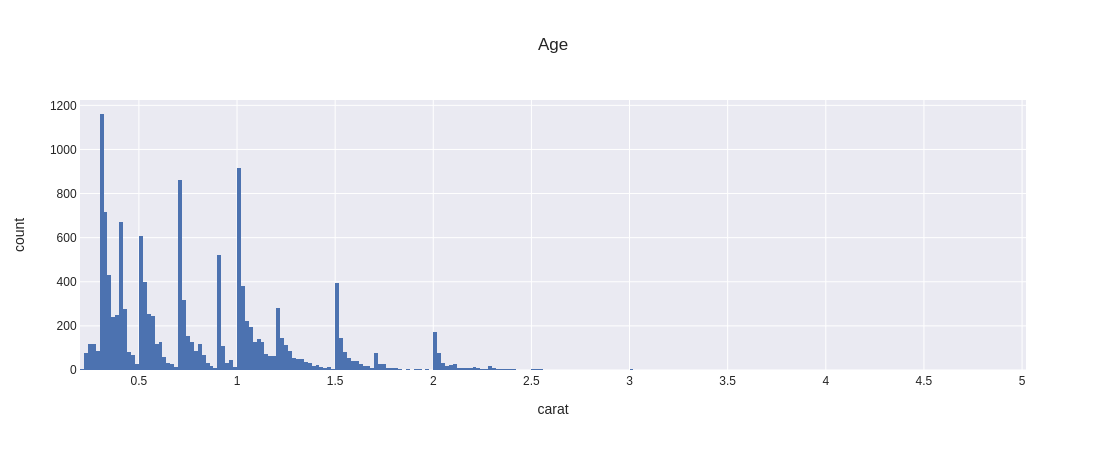

In [23]:
fig=px.histogram(PROBA, x='carat',nbins=400,template='seaborn',title='Age',barmode='group')
fig.show()

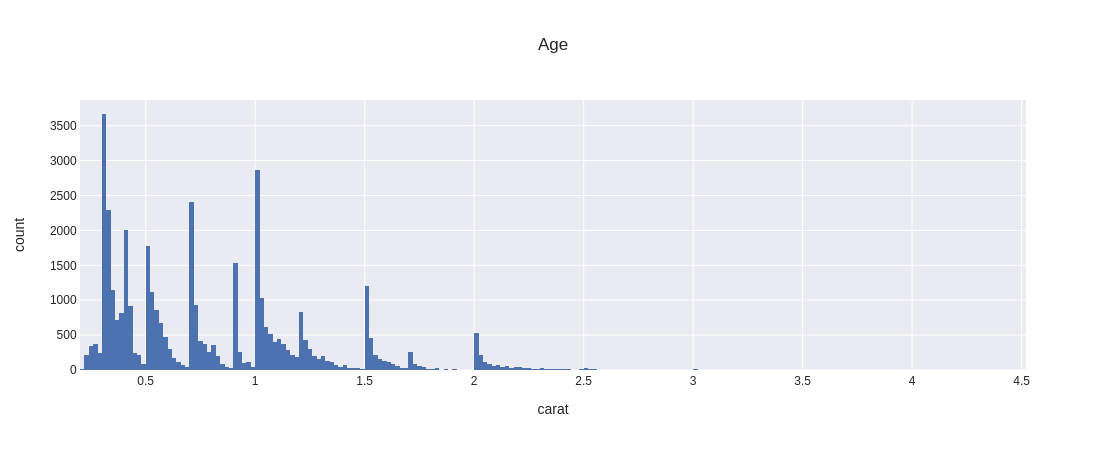

In [24]:
fig=px.histogram(X, x='carat',nbins=400,template='seaborn',title='Age',barmode='group')
fig.show()